# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

## Importações e Reprodutibilidade

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

## Dados

In [2]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
full_val_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = torch.arange(5000)
val_indices = torch.arange(1000)

train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_val_dataset, val_indices)

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


## Funções auxiliares

In [3]:
def count_parameters(model):
    """
    Conta o número total de parâmetros treináveis em um modelo.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def evaluate_model(model, val_loader, criterion):
    """
    Avalia a perda e a acurácia de um modelo no conjunto de validação.
    """
    model.eval()  # Coloca o modelo em modo de avaliação
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """
    Função para treinar e validar um modelo, retornando o histórico de métricas.
    """
    # Dicionário para armazenar as métricas
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()  # Modo de treinamento
        running_train_loss = 0.0

        # Loop de treinamento
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)

        # Avaliação ao final da época
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        # Armazena as métricas
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    print("Treinamento concluído.")
    return history

In [6]:
def plot_curves(history):
    """
    Plota as curvas de perda e acurácia.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Perda (Loss)
    ax1.plot(history['train_loss'], label='Perda de Treinamento')
    ax1.plot(history['val_loss'], label='Perda de Validação')
    ax1.set_title('Curvas de Perda')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)

    # Plot de Acurácia
    ax2.plot(history['val_accuracy'], label='Acurácia de Validação', color='g')
    ax2.set_title('Curva de Acurácia')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Acurácia (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

## Exercícios

### Exercício 1

Em vez de usar `nn.Sequential` para todo o modelo, uma prática mais comum e flexível é definir a arquitetura dentro de uma classe que herda de `nn.Module`. Isso nos permite organizar o modelo em seções lógicas.

Neste exercício, construa um modelo mais profundo, com três ou mais blocos convolucionais, e os organize em duas partes dentro de uma classe:
1.  Um extrator de features (`feature_extractor`), contendo as camadas convolucionais e de pooling.
2.  Um classificador (`classifier`), contendo as camadas `Flatten`, `Linear` e `Dropout`.

In [7]:
class DeeperModel(nn.Module):
    def __init__(self):
        super(DeeperModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            # Bloco 1: [N, 1, 28, 28] -> [N, 16, 14, 14]
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 2: [N, 16, 14, 14] -> [N, 32, 7, 7]
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 3: [N, 32, 7, 7] -> [N, 64, 3, 3]
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 4: [N, 64, 3, 3] -> [N, 128, 1, 1]
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # [N, 128, 1, 1]
            nn.Linear(128 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

Epoch [1/10], Train Loss: 1.2439, Val Loss: 0.3624, Val Accuracy: 88.60%
Epoch [2/10], Train Loss: 0.2743, Val Loss: 0.2354, Val Accuracy: 91.80%
Epoch [3/10], Train Loss: 0.1681, Val Loss: 0.1575, Val Accuracy: 94.60%
Epoch [4/10], Train Loss: 0.1269, Val Loss: 0.1175, Val Accuracy: 96.30%
Epoch [5/10], Train Loss: 0.0821, Val Loss: 0.1151, Val Accuracy: 95.90%
Epoch [6/10], Train Loss: 0.0834, Val Loss: 0.1468, Val Accuracy: 94.50%
Epoch [7/10], Train Loss: 0.0767, Val Loss: 0.0843, Val Accuracy: 97.20%
Epoch [8/10], Train Loss: 0.0423, Val Loss: 0.0839, Val Accuracy: 97.20%
Epoch [9/10], Train Loss: 0.0442, Val Loss: 0.0925, Val Accuracy: 97.20%
Epoch [10/10], Train Loss: 0.0371, Val Loss: 0.0599, Val Accuracy: 97.80%
Treinamento concluído.


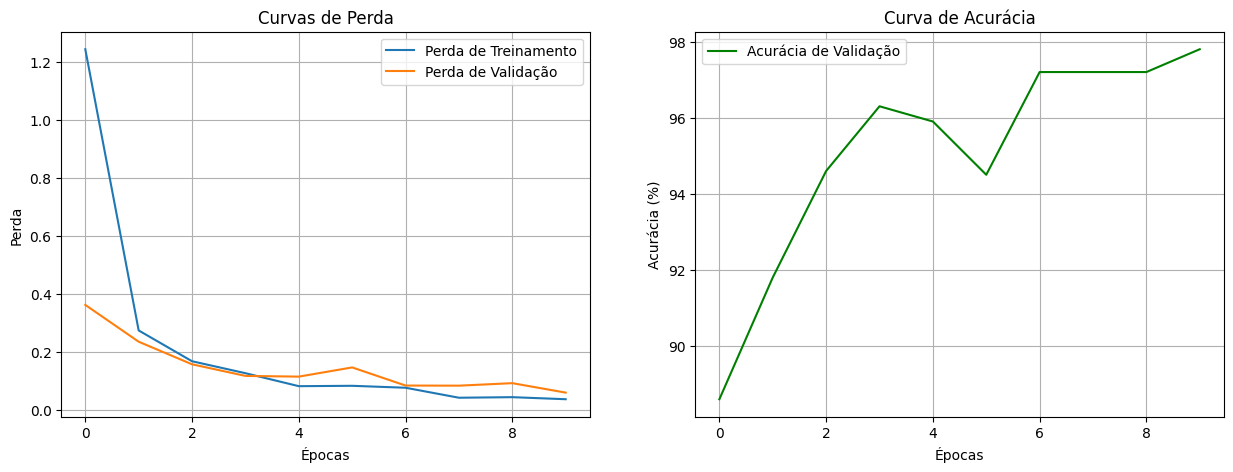

In [8]:
# Instanciando
model = DeeperModel()

# Critério de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Treinando o modelo
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Plotando as curvas
plot_curves(history)

### Exercício 2

Considere que ao invés do MNIST, os dados de entrada são imagens RGB no formato `(3, 32, 32)`. Implemente uma CNN para classificar essas imagens em 10 classes.

In [10]:
class RGBModel(nn.Module):
    def __init__(self, num_classes=10):
        super(RGBModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            # Bloco 1: [N, 3, 32, 32] -> [N, 32, 16, 16]
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 2: [N, 32, 16, 16] -> [N, 64, 8, 8]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 3: [N, 64, 8, 8] -> [N, 128, 4, 4]
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # [N, 128, 4, 4]
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x